This notebook analyzes various experiments with specific hyperparameters, including `Cutoff`, `Processing Layers`, `Transformer Layers`, and `Attention Drop`, across different architectures: `MLP`, `Graph Network`, `Equivariant Network`, `MLP with energy embeddings`, `Graph Network with energy embeddings`, and `DOSTransformer`. All necessary experimental configuration details are loaded into a `Pandas DataFrame`. Subsequently, the best experiments are selected based on the `RMSE` evalauted on the `validation dataset`.

In [1]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def extract_experiment_config(expt_file):
    """Extracts the necessary config details about the experiment."""
    expt_config = {
        "Embedder": None,
        "Cutoff": None,
        "Layers": None,
        "Transformer": None,
        "Attn. Drop": None,
        "Best Epoch": None,
        "Best RMSE": None,
        "Best MSE": None,
        "Best MAE": None,
        "Best R2": None,
        "Wall Time": None,
        "Run Dir": None,
        "Last Epoch": None
    }

    with open(expt_file, "r") as fi:
        contents = fi.readlines()

        for i, line in enumerate(contents):
            if "hidden" not in line:
                if "r_max" in line:
                    expt_config["Cutoff"] = float(line.split(":")[-1])
                elif "embedder" in line:
                    expt_config["Embedder"] = line.split(": ")[-1].replace("\n", "").strip()
                elif "layers" in line:
                    expt_config["Layers"] = int(line.split(":")[-1])
                elif "transformer" in line:
                    expt_config["Transformer"] = int(line.split(":")[-1])
                elif "attn_drop" in line:
                    expt_config["Attn. Drop"] = float(line.split(":")[-1])
            else:
                break

        #print(expt_config['Embedder']")

        if expt_config["Embedder"]  in ["mlp", "mlp2", "e3nn"]:
            expt_config["Embedder"] = expt_config.get("Embedder").upper()

        elif expt_config["Embedder"]  in ["graphnetwork", "graphnetwork2"]:
            expt_config["Embedder"] = expt_config.get("Embedder").replace("graph", "graph ").title()
        else: #DOSTransformer
            expt_config["Embedder"] = expt_config.get("Embedder").replace("dost", "DOST")

        for i, line in enumerate(contents[-7:]):
            if "Best Epoch" in line:
                expt_config["Best Epoch"] = int(line.split(":")[-1])
            elif "RMSE" in line:
                expt_config["Best RMSE"] = float(line.split(":")[-1])
            elif "MSE" in line:
                expt_config["Best MSE"] = float(line.split(":")[-1])
            elif "MAE" in line:
                expt_config["Best MAE"] = float(line.split(":")[-1])
            elif "R2" in line:
                expt_config["Best R2"] = float(line.split(":")[-1])
            elif "Total time" in line:
                time_string = line.split(": ")[-1].replace("\n", "")
                time_object = datetime.strptime(time_string, "%H:%M:%S")
                expt_config["Wall Time"] = timedelta(
                    hours=time_object.hour,
                    minutes=time_object.minute,
                    seconds=time_object.second
                ).total_seconds()

        expt_config["Run Dir"] = expt_file.parent.resolve()

        expt_config["Last Epoch"] = int(contents[-14].split("]:")[0].replace("[ Epoch ", ""))

    return expt_config


architecture_list = [
    "mlp",
    "graphnetwork",
    "mlp2",
    "graphnetwork2",
    "e3nn",
    "dostransformer"
]


expt_df = pd.DataFrame()

for architecture in architecture_list:
    for architecture_dir in Path("../experiments").joinpath(f"{architecture}").iterdir():
        file = architecture_dir.joinpath("expt.txt")
        expt_config = extract_experiment_config(file)
        expt_df = pd.concat([expt_df, pd.DataFrame([expt_config])], ignore_index=True)

expt_df.info()

/tmp/ipykernel_2042468/1912769262.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expt_df = pd.concat([expt_df, pd.DataFrame([expt_config])], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Embedder     84 non-null     object 
 1   Cutoff       84 non-null     float64
 2   Layers       84 non-null     int64  
 3   Transformer  54 non-null     object 
 4   Attn. Drop   54 non-null     float64
 5   Best Epoch   84 non-null     int64  
 6   Best RMSE    84 non-null     float64
 7   Best MSE     84 non-null     float64
 8   Best MAE     84 non-null     float64
 9   Best R2      84 non-null     float64
 10  Wall Time    84 non-null     float64
 11  Run Dir      84 non-null     object 
 12  Last Epoch   84 non-null     int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 8.7+ KB


# Best Experiment for each architecture

In [2]:
best_expt_df = expt_df.loc[expt_df.groupby("Embedder")["Best RMSE"].idxmin()].fillna("-")

best_expt_df.iloc[:, :-3]

,Embedder,Cutoff,Layers,Transformer,Attn. Drop,Best Epoch,Best RMSE,Best MSE,Best MAE,Best R2
54,DOSTransformer,8.0,4,4,0.2,70,0.1423,0.0242,0.0911,0.7042
27,E3NN,8.0,4,-,-,500,0.1817,0.0341,0.1062,0.5824
7,Graph Network,2.0,3,-,-,110,0.1635,0.0277,0.1102,0.6619
21,Graph Network2,8.0,4,-,-,70,0.1852,0.0350,0.1177,0.5710
0,MLP,4.0,4,-,-,40,0.1596,0.0266,0.0955,0.6771
12,MLP2,4.0,4,-,-,30,0.1718,0.0311,0.1098,0.6232


# Loss Curves of best model from each architecture

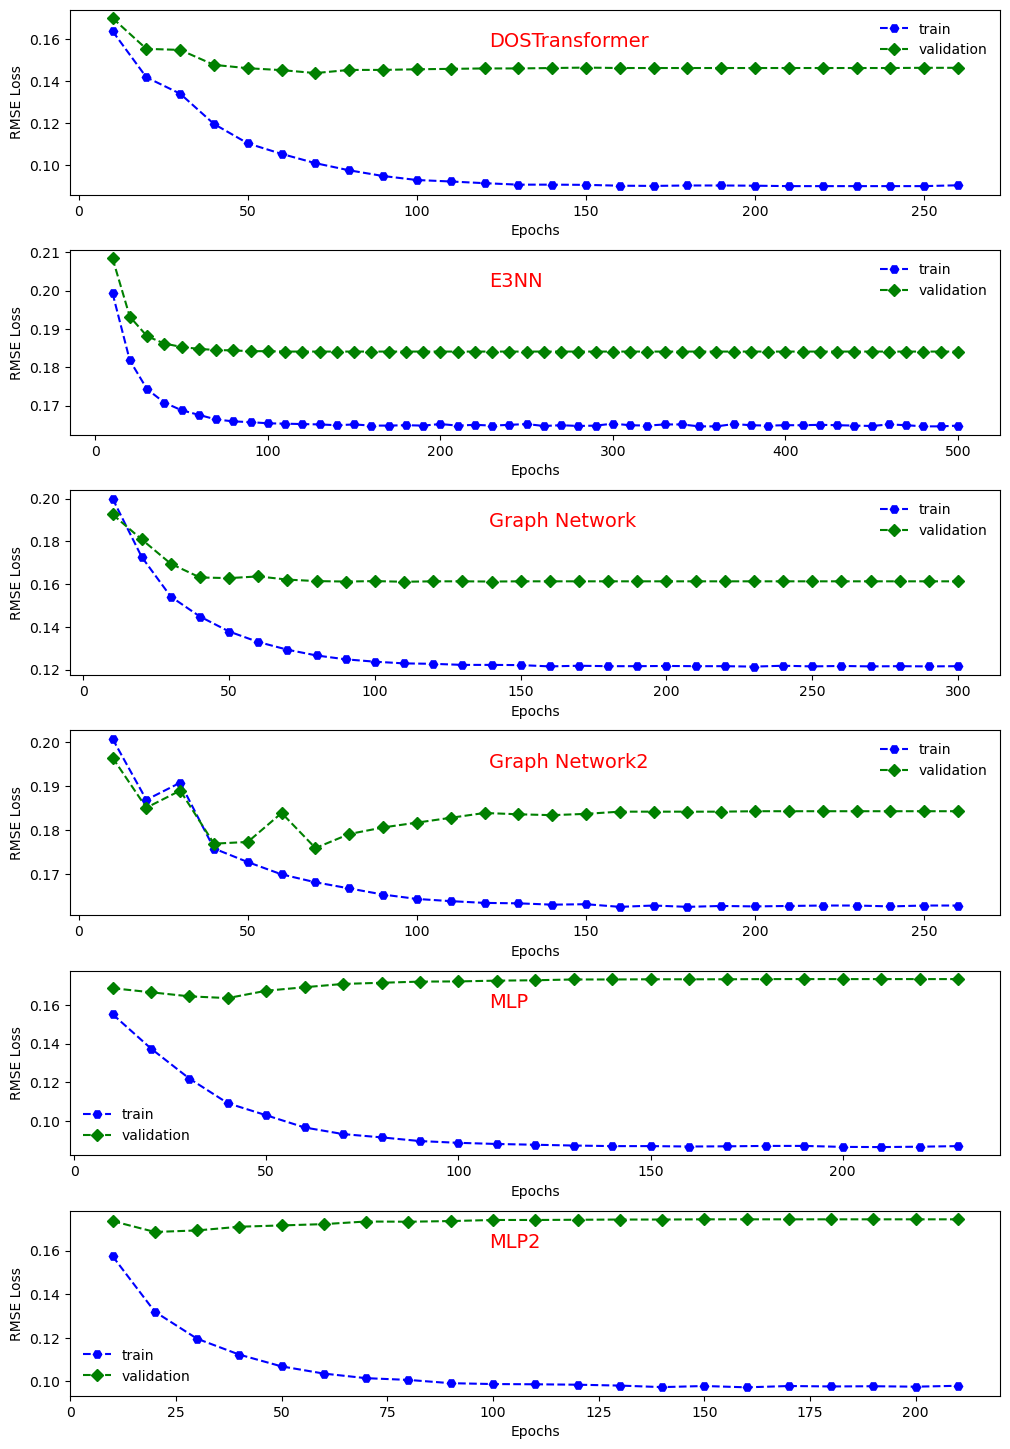

In [8]:
def extract_loss(expt_file):
    """Extract the train & validation losses of the experiment."""
    epochs, train_loss, val_loss = [], [], []

    with open(expt_file, "r") as fi:
        contents = fi.readlines()

    for i, line in enumerate(contents):
        if line.strip() == "Start training":
            break

    train_contents = contents[i+4: -12]  # training info

    j = 0

    while(j < len(train_contents)):

        line = train_contents[j]

        if "train" in line:
            line = line.replace(" |", "")
            epoch_num = int(line.split("]:")[0].split()[-1])
            train_rmse = float(line.split("]:")[-1].split()[1])

            val_line = train_contents[j+1].replace(" |", "")
            val_rmse = float(val_line.split("]:")[-1].split()[1])

            epochs.append(epoch_num)
            train_loss.append(train_rmse)
            val_loss.append(val_rmse)
            j += 5

        else:
            j += 1

    return epochs, train_loss, val_loss


fig, axes = plt.subplots(6, 1, figsize=(12, 18))

for i, architecture in enumerate(best_expt_df["Embedder"].to_list()):
    model_dict = best_expt_df[best_expt_df["Embedder"] == architecture].to_dict(orient="split", index=False)["data"][0]
    expt_file = f"{str(model_dict[-2])}/expt.txt"
    epochs, train_loss, val_loss = extract_loss(expt_file)

    axes[i].plot(epochs, train_loss, "bH--", label="train")
    axes[i].plot(epochs, val_loss, "gD--", label="validation")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("RMSE Loss")
    axes[i].legend(frameon=False)
    axes[i].annotate(f"{architecture}", (0.45, 0.8), xycoords="axes fraction", fontsize=14, color="r")


plt.subplots_adjust(hspace=0.3)

plt.savefig("../figures/best_loss_curves.png", dpi=300)
plt.show()
